In [1]:
import glob
import os
import librosa
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
%matplotlib inline

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical 


import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from livelossplot.inputs.tf_keras import PlotLossesCallback


from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where


from scipy.io import wavfile as wav
import struct
import IPython.display as ipd
import plotly.graph_objects as go
plt.style.use('ggplot')


In [2]:
xgb.__version__

'1.4.1'

In [3]:
# constants

NP_TRAIN_DATASET = 'dataset_train.npy'
NP_TEST_DATASET = 'dataset_test.npy'
DATA_PATH = "../../../datasets/FSD50K/"
#DATA_PATH = "../../../data_sets/FSD50K/"
CSV_TRAIN = "train_df.csv"
CSV_TEST = "test_df.csv"

In [4]:
#para melhor gestão memória GPU por parte do tensorflow

def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        # Allow memory growth for the GPU
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print(physical_devices)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)


def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")

A acertar o backend e libertar memória da grafica
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
train_df = pd.read_csv(CSV_TRAIN, sep=';')
test_df = pd.read_csv(CSV_TEST, sep= ';')

print("Number of training examples: %d"%(train_df.shape[0]))
print("Number of tesing examples: %d"%(test_df.shape[0]))
print("Number of Classes: %d"%(train_df.labels.nunique()))
#print("Classes: ",train_df.labels.unique())

Number of training examples: 39566
Number of tesing examples: 9897
Number of Classes: 262


In [6]:
def load_data(np_dataset):
    std = StandardScaler()
    data = pd.DataFrame(np.load(np_dataset,allow_pickle= True))
    data.columns = ['mfccs', 'chroma', 'mel', 'contrast', 'tonnetz', 'label']
    mfcss = np.array(data.mfccs.tolist(), dtype=object)
    chroma = np.array(data.chroma.tolist(), dtype=object)
    mel = np.array(data.mel.tolist(), dtype=object)
    contrast = np.array(data.contrast.tolist(), dtype=object)
    tonnetz = np.array(data.tonnetz.tolist(), dtype=object)
    features = np.hstack([mfcss, chroma, mel, contrast, tonnetz])
    X = np.array(features, dtype=object)
    std.fit(X)
    Y = np.array(data.label.tolist())

    X.shape, Y.shape, X[0].reshape(1,X[0].shape[0]).shape
    
    lb = LabelEncoder()
    print('x',X.shape)
    print('y',Y.shape)
    return (X, Y)
    
(x_train, y_train) = load_data(NP_TRAIN_DATASET)
(x_test, y_test) = load_data(NP_TEST_DATASET)

x (39566, 193)
y (39566,)
x (9897, 193)
y (9897,)


In [7]:
lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))


train = np.argmax(y_train,axis =  1)
test = np.argmax(y_test,axis =  1)

In [8]:
print(x_train.shape)
print(train.shape)
print(x_test.shape)
print(test.shape)

(39566, 193)
(39566,)
(9897, 193)
(9897,)


In [9]:
gpu = {"updater": "gpu_hist"}

clf_xgb = xgb.XGBClassifier(seed=42,
    learning_rate=0.1,
    n_estimators=170,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    predictor = 'gpu_predictor',
    tree_method='gpu_hist', gpu_id=0)

#(x_train, y_train, x_test, y_test)

clf_xgb.fit(x_train,train.ravel(),
           verbose=False,
            early_stopping_rounds=50,
            eval_metric='merror',
            eval_set=[(x_test, test.ravel())])

#clf_xgb.fit(x_train,train)

y_predict = clf_xgb.predict(x_test)
y_train_predict = clf_xgb.predict(x_train)

print(f'Training accuracy:        {accuracy_score(train,  y_train_predict)*100: .2f}%')
print(f'Validation accuracy:      {accuracy_score(test, y_predict)*100: .2f}%')

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training accuracy:         86.65%
Validation accuracy:       15.77%


In [10]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return indices

In [11]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

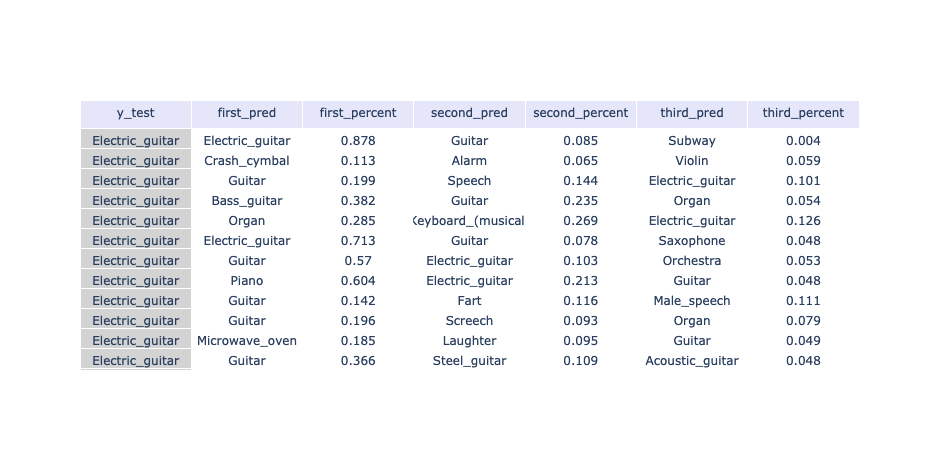

In [19]:
def print_series_prediction(sound, label):
    sounds = []
    first_preds = []
    first_percent = []
    second_preds = []
    second_percent = []
    third_preds = []
    third_percent = []
    for i in range(len(sound)): #para imprimir tabela de previsoes
        predictions = clf_xgb.predict_proba(sound)
        predic = largest_indices(predictions[i], 3)
        percentage = predictions[i][predic]
        
        sounds.append(label[i])

        first_preds.append(lb.inverse_transform(predic)[0])
        first_percent.append(truncate(percentage[0],3))
        second_preds.append(lb.inverse_transform(predic)[1])
        second_percent.append(truncate(percentage[1],3))
        third_preds.append(lb.inverse_transform(predic)[2])
        third_percent.append(truncate(percentage[2],3))
       
    data = {'y_test':  sounds,
            'first_pred': first_preds,
            'first_percent': first_percent,
            'second_pred': second_preds,
            'second_percent': second_percent,
            'third_pred': third_preds,
            'third_percent': third_percent
           }
    df = pd.DataFrame(data)
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='lavender',
                align='center'),
    cells=dict(values=[df.y_test, df.first_pred, df.first_percent,
                       df.second_pred, df.second_percent, df.third_pred, df.third_percent
                      ],
               #fill_color='lightgrey',
               fill=dict(color=['lightgrey', 'white']),
               align='center'))])

    fig.show()
    return df

df = print_series_prediction(x_test,  lb.inverse_transform(test))

In [20]:
df.to_csv('test_emotion_dataset.csv', sep=',')

In [ ]:
df_treino = print_series_prediction(x_train,  lb.inverse_transform(train))

In [ ]:
df_treino.to_csv('train_emotion_dataset.csv', sep=',')